Online Retail Customer Segmentation Analysis

Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab
import datetime
import scipy
import scipy.stats as stats
import seaborn as sns

import os

Import the dataset

In [2]:
OR_df=pd.read_excel('Online Retail.xlsx')
OR_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

Exploratory data analysis

In [3]:
OR_df.Country.value_counts().reset_index().head(20)

index  Country
0    United Kingdom   495478
1           Germany     9495
2            France     8557
3              EIRE     8196
4             Spain     2533
5       Netherlands     2371
6           Belgium     2069
7       Switzerland     2002
8          Portugal     1519
9         Australia     1259
10           Norway     1086
11            Italy      803
12  Channel Islands      758
13          Finland      695
14           Cyprus      622
15           Sweden      462
16      Unspecified      446
17          Austria      401
18          Denmark      389
19            Japan      358

The unique customers of the retailer having customer ID and their percentage of orders by top 10 orders.

In [4]:
OR_df.CustomerID.unique().shape

(4373,)

In [5]:
(OR_df.CustomerID.value_counts()/sum(OR_df.CustomerID.value_counts())*100).head(13).cumsum()

17841.0    1.962249
14911.0    3.413228
14096.0    4.673708
12748.0    5.814728
14606.0    6.498553
15311.0    7.110850
14646.0    7.623350
13089.0    8.079807
13263.0    8.492020
14298.0    8.895138
15039.0    9.265809
14156.0    9.614850
18118.0    9.930462
Name: CustomerID, dtype: float64

Out of 4373 unique customers only 13 were ordered the 10% of the  total sales of retailer based on
cumulative sum.

In [6]:
OR_df.StockCode.unique().shape

(4070,)

In [7]:
OR_df.Description.unique().shape

(4224,)

From the above, we observed that there is a mismatch between StockCode and Description and also number of Descriptions
more than the Stock code values,which means that we have multiple descriptions for some of the Stockcodes.

In [8]:
des_df=OR_df.groupby(['Description','StockCode']).count().reset_index()
des_df.StockCode.value_counts()[des_df.StockCode.value_counts()>1].reset_index().head()

index  StockCode
0  20713          8
1  23084          7
2  21830          6
3  85175          6
4  23343          5

In [9]:
OR_df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [10]:
OR_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

The output of the two attributes having negitive values,which means that may have some return transactions in this data.

The RFM (Recency,Frequency,Monetary value) based model of customer value for finding the customer segments.


Data preprocessing

Separate data for one geography

In [11]:
OR_df=OR_df[OR_df.Country=='United Kingdom']
OR_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

Separate attribute based on amount

In [12]:
OR_df['Amount']=OR_df.Quantity*OR_df.UnitPrice
OR_df['Amount'].head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: Amount, dtype: float64

Remove negative or return transactions

In [13]:
OR_df=OR_df[~(OR_df['Amount']<0)]
OR_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34

Remove transactions having missing values for the Customer ID field

In [14]:
OR_df=OR_df[~(OR_df.CustomerID.isnull())]
print(OR_df.shape)
OR_df.head()

(354345, 9)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34

Create the RFM model (Recency, Frequency,Monetary value)

Recency

To create a Recency feature variable, we need to decide the reference date for analysis and we wil define the reference date as one day before the last transaction.

In [15]:
reference_date=OR_df.InvoiceDate.max()
reference_date=reference_date+datetime.timedelta(days=1)#timedelta function returns to total number of seconds
print(OR_df.InvoiceDate.max(),OR_df.InvoiceDate.min())
reference_date

2011-12-09 12:49:00 2010-12-01 08:26:00


Timestamp('2011-12-10 12:49:00')

We will construct a reference variable as number of days before the reference date when a customer last made a purchase.

In [16]:
OR_df['days_since_last_purchase']=reference_date-OR_df.InvoiceDate
OR_df['days_since_last_purchase_num']=OR_df['days_since_last_purchase'].astype('timedelta64[D]')
OR_df['days_since_last_purchase_num'].head()                                                                

0    374.0
1    374.0
2    374.0
3    374.0
4    374.0
Name: days_since_last_purchase_num, dtype: float64

Customer history of last transactions

In [17]:
customer_history_df = OR_df[['CustomerID', 'days_since_last_purchase_num']].groupby('CustomerID').min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase_num':'Recency'}, inplace=True)
print(customer_history_df.describe())
customer_history_df.head()

         CustomerID      Recency
count   3921.000000  3921.000000
mean   15561.471563    92.188472
std     1576.823683    99.528995
min    12346.000000     1.000000
25%    14208.000000    18.000000
50%    15569.000000    51.000000
75%    16913.000000   143.000000
max    18287.000000   374.000000


CustomerID  Recency
0     12346.0    326.0
1     12747.0      2.0
2     12748.0      1.0
3     12749.0      4.0
4     12820.0      3.0

Distribution of customer recency

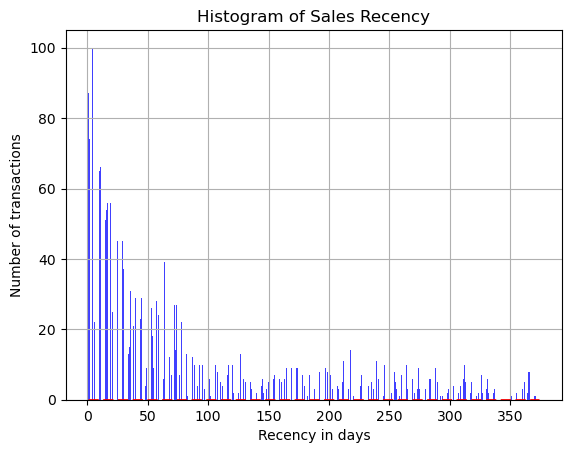

In [18]:
x=customer_history_df.Recency
mu=np.mean(x)
sigma=math.sqrt(np.var(x))
n,bins,patches=plt.hist(x,1000,facecolor='blue',alpha=0.75)#alpha=transparency parameter
# Add a best fit line
y=scipy.stats.norm.pdf(bins,mu,sigma)#norm.pdf-probability density function for norm
l=plt.plot(bins,y,'r--',lw=2)

plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title('Histogram of Sales Recency')
plt.grid(True)
plt.show()

We have a skewd distribution of sales recency with a much higher frequent number of transactions and a fairly unifirm number of sales less in recent transactions.

Frequency and Monetary value

In [19]:
customer_monetary_val=OR_df[['CustomerID','Amount']].groupby('CustomerID').sum().reset_index()
customer_history_df=customer_history_df.merge(customer_monetary_val,how='outer')
customer_history_df.Amount=customer_history_df.Amount+0.001
customer_freq=OR_df[['CustomerID','Amount']].groupby('CustomerID').count().reset_index()
customer_freq.rename(columns={'Amount':'Frequency'},inplace=True)
customer_history_df=customer_history_df.merge(customer_freq,how='outer')

customer_history_df=pd.DataFrame(customer_history_df,columns=['CustomerID','Recency','Amount','Frequency'])
customer_history_df.head()

CustomerID  Recency     Amount  Frequency
0     12346.0    326.0  77183.601          1
1     12747.0      2.0   4196.011        103
2     12748.0      1.0  33719.731       4596
3     12749.0      4.0   4090.881        199
4     12820.0      3.0    942.341         59

Data Preprocessing

In [20]:
from sklearn import preprocessing
customer_history_df['Recency_log'] = customer_history_df['Recency'].apply(math.log)
customer_history_df['Frequency_log'] = customer_history_df['Frequency'].apply(math.log)
customer_history_df['Amount_log'] = customer_history_df['Amount'].apply(math.log)
feature_vector=['Recency_log','Frequency_log','Amount_log']
X=customer_history_df[feature_vector].values
scaler=preprocessing.StandardScaler()
X_scaled=scaler.fit_transform(X)

Visualizing Recency and Frequency vs Monetary Value (Scaled)

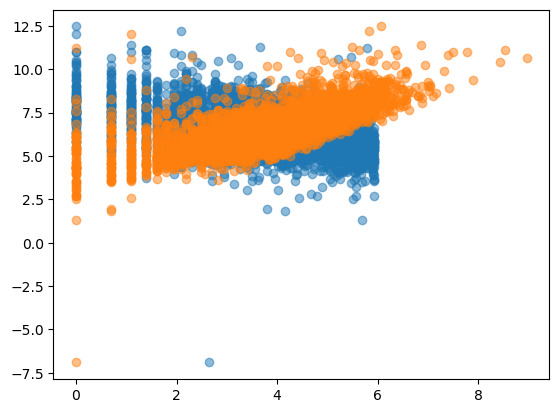

In [21]:
plt.scatter(customer_history_df.Recency_log,customer_history_df.Amount_log,alpha=0.5)

plt.scatter(customer_history_df.Frequency_log,customer_history_df.Amount_log,alpha=0.5)

Visualizing Monetary Value distribution

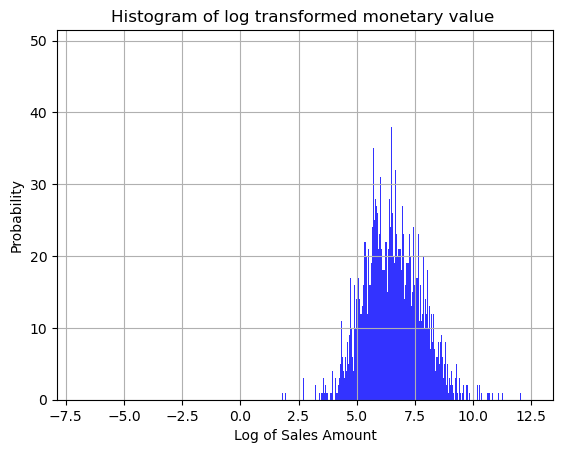

In [22]:
x=customer_history_df.Amount_log
n,bins,patches=plt.hist(x,1000,facecolor='b',alpha=0.8)
plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title('Histogram of log transformed monetary value ')
plt.grid(True)
plt.show()

Clustering for Customer segements by using EM Custering algorithm.

Customer segmentation for Recency vs Monetary Value for 3 and 5 clusters

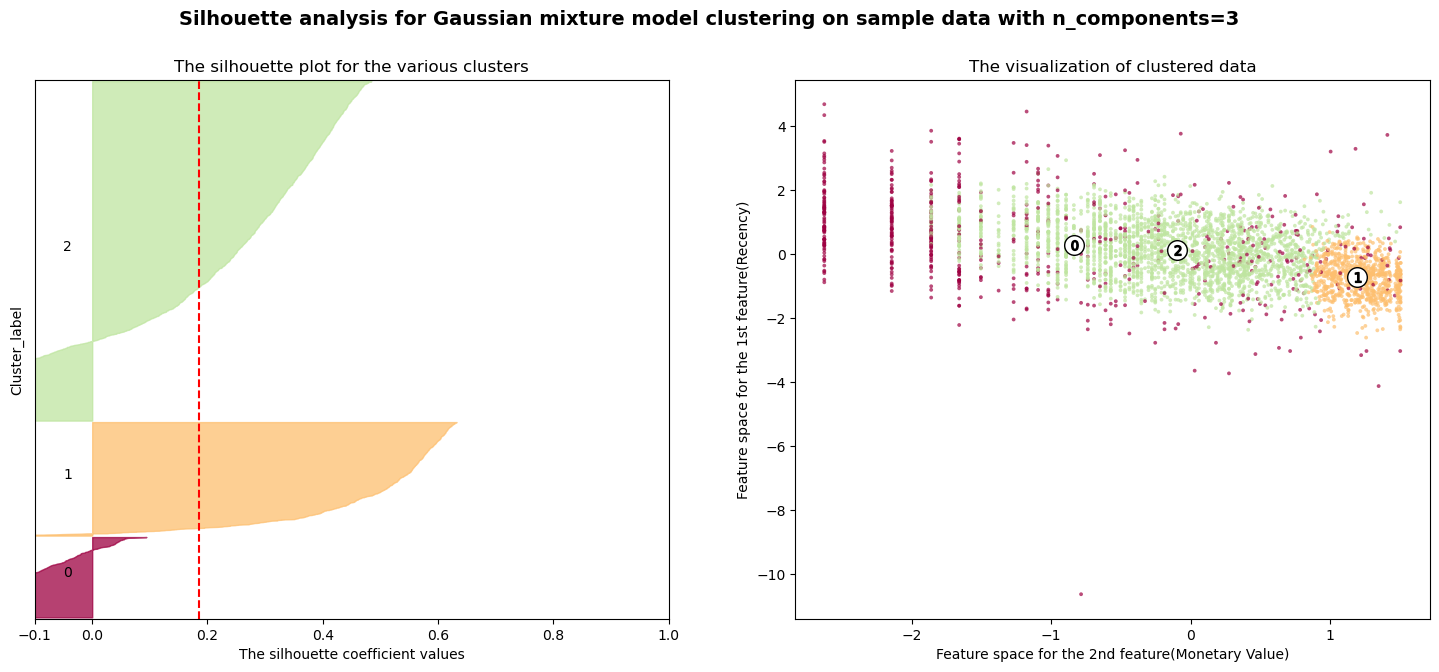

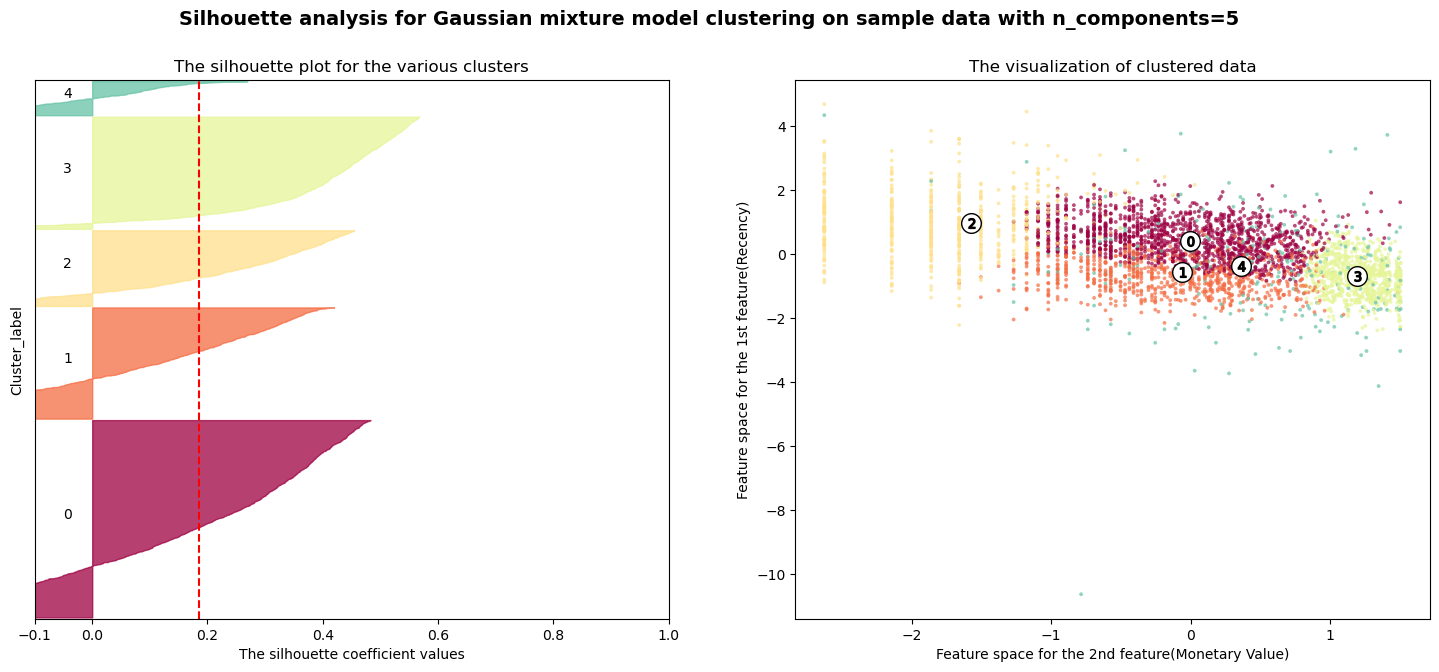

In [23]:
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

X = X_scaled
cluster_centers = dict()

for n_components in range(3, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_components + 1) * 10])

    gmm = GaussianMixture(n_components=n_components, random_state=10)
    cluster_labels = gmm.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_components: {'cluster_centre': gmm.means_,
                                           'silhouette_score': silhouette_avg,
                                           'labels': cluster_labels}
                             })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_components):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_components)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.75)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for 0 samples

    ax1.set_title('The silhouette plot for the various clusters')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster_label')
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cmap(cluster_labels.astype(float) / n_components)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30,
                lw=0, alpha=0.7, edgecolor='k', c=colors)
    centers = gmm.means_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker="o",
                alpha=1, c='white', s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    edgecolor='k', s=50)
    ax2.set_title('The visualization of clustered data')
    ax2.set_xlabel('Feature space for the 2nd feature(Monetary Value)')
    ax2.set_ylabel('Feature space for the 1st feature(Recency)')
    plt.suptitle('Silhouette analysis for Gaussian mixture model clustering on sample data '
                 'with n_components=%d' % n_components, fontsize=14, fontweight='bold')
    plt.show()


Customer segmentation for Recency vs Monetary Value for 5 and 7 clusters

Davies-Bouldin Index

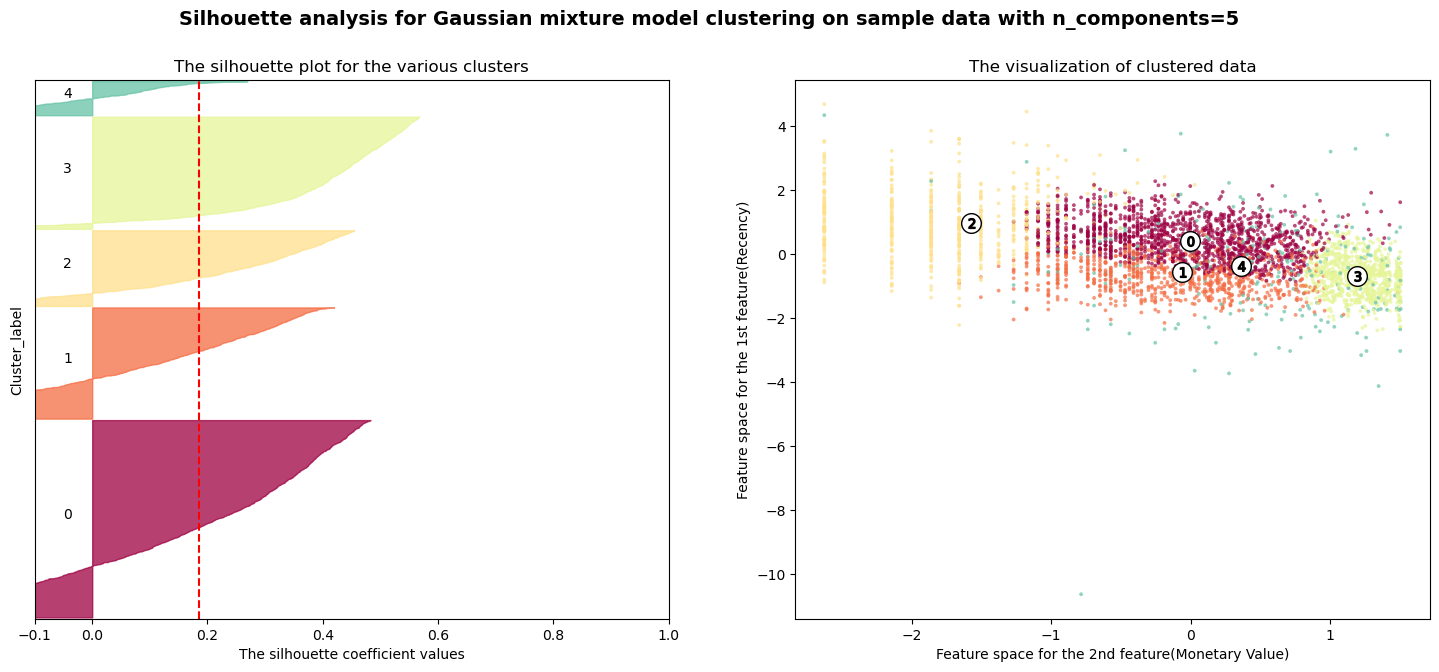

Davies-Bouldin Index for n_components=5: 1.461677


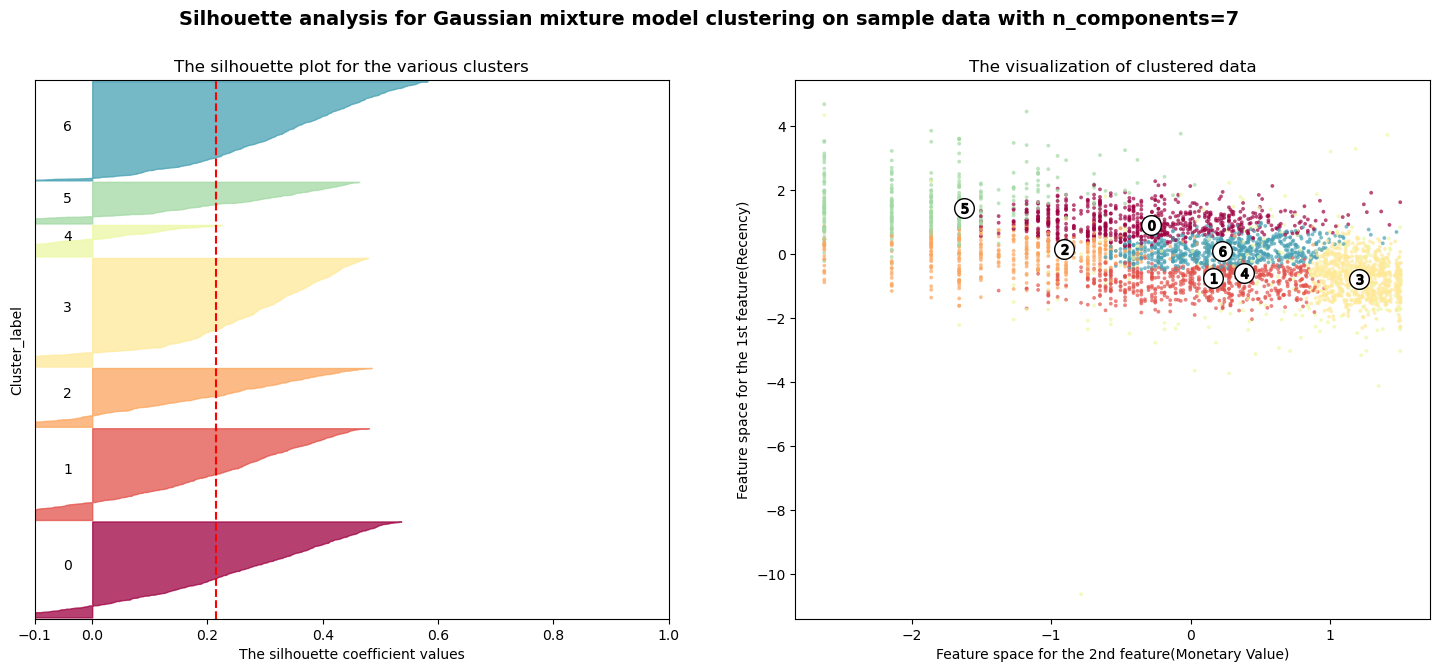

Davies-Bouldin Index for n_components=7: 1.317715


In [24]:
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm

X = X_scaled
cluster_centers = dict()

for n_components in range(5, 8, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_components + 1) * 10])

    gmm = GaussianMixture(n_components=n_components, random_state=10)
    cluster_labels = gmm.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    cluster_centers.update({n_components: {'cluster_centre': gmm.means_,
                                           'silhouette_score': silhouette_avg,
                                           'davies_bouldin_score': db_score,
                                           'labels': cluster_labels}
                             })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_components):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_components)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.75)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for 0 samples

    ax1.set_title('The silhouette plot for the various clusters')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster_label')
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cmap(cluster_labels.astype(float) / n_components)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30,
                lw=0, alpha=0.7, edgecolor='k', c=colors)
    centers = gmm.means_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker="o",
                alpha=1, c='white', s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    edgecolor='k', s=50)
    ax2.set_title('The visualization of clustered data')
    ax2.set_xlabel('Feature space for the 2nd feature(Monetary Value)')
    ax2.set_ylabel('Feature space for the 1st feature(Recency)')
    plt.suptitle('Silhouette analysis for Gaussian mixture model clustering on sample data '
                 'with n_components=%d' % n_components, fontsize=14, fontweight='bold')
    plt.show()

    # Davies-Bouldin Index
    from sklearn.metrics import davies_bouldin_score
    dbi = davies_bouldin_score(X, cluster_labels)
    print("Davies-Bouldin Index for n_components=%d: %f" % (n_components, dbi))



Cluster Segmentation for Frequency vs Monetary value for 5 and 7 clusters

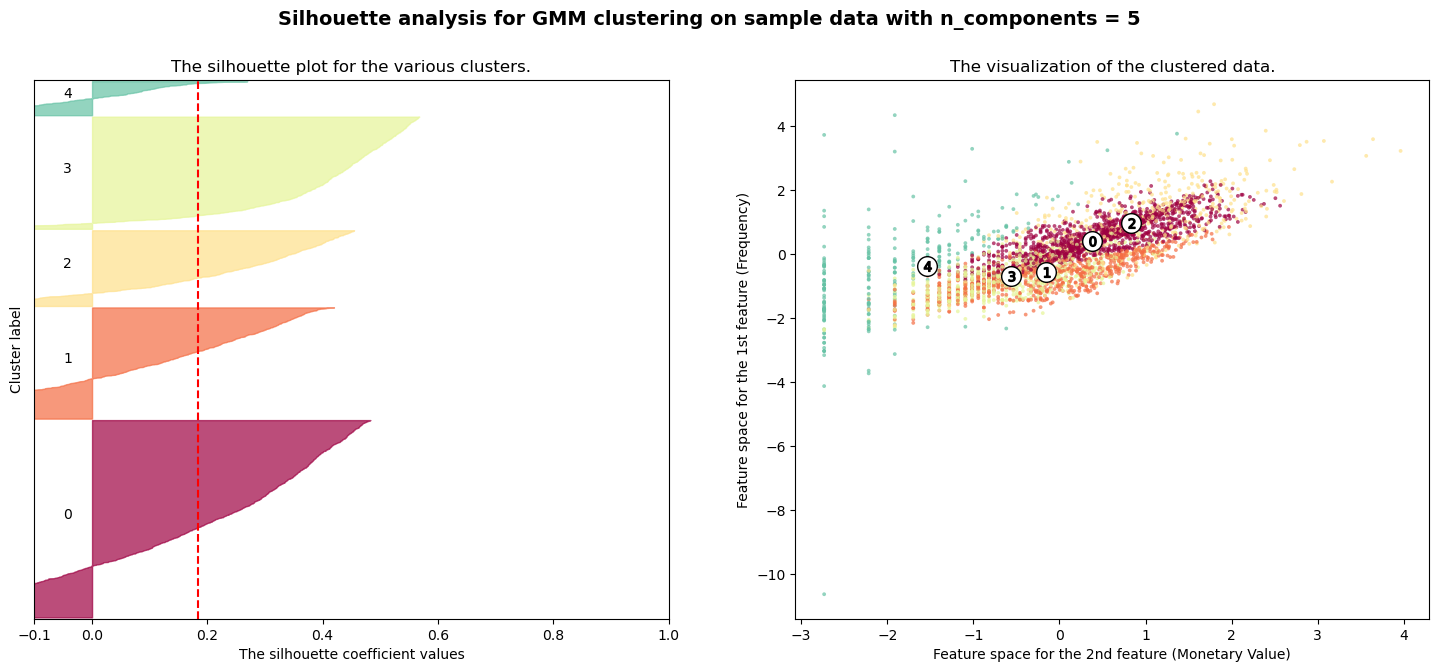

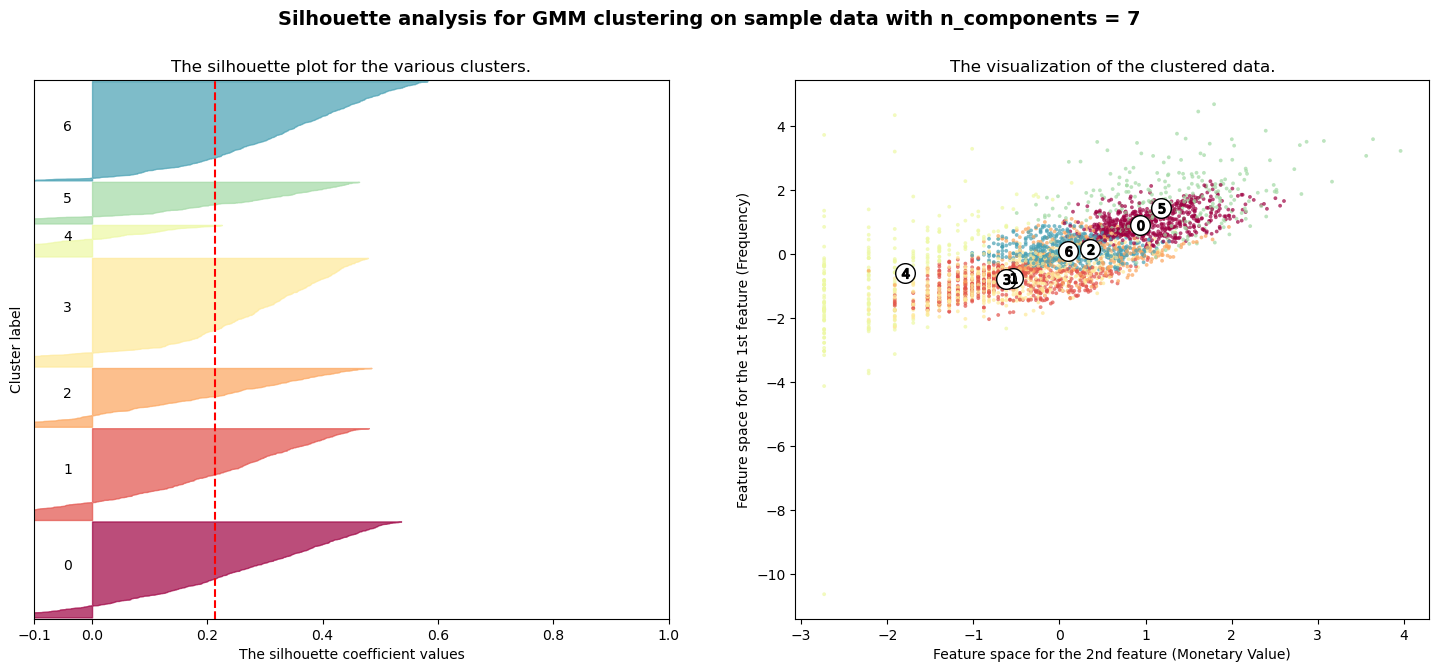

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(5,8,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    gmm = GaussianMixture(n_components=n_clusters, random_state=10)
    cluster_labels = gmm.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':gmm.means_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap=cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    feature1 = 1
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = gmm.means_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 2nd feature (Monetary Value)")
    ax2.set_ylabel("Feature space for the 1st feature (Frequency)")
    plt.suptitle(("Silhouette analysis for GMM clustering on sample data "
                  "with n_components = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


Cluster analysis

In [26]:
for i in range(5,8,2):
    print('for {} number of clusters'.format(i))
    cent_transformed=scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print('Silhouette score for cluster {} is {}'.format(i,cluster_centers[i]['silhouette_score']))
    

for 5 number of clusters
   Recency_log  Frequency_log   Amount_log
0    42.756005      64.687611  1172.020230
1    39.414721      31.660282   337.156199
2     4.537704     118.637934  2328.084498
3   237.479425      18.219857   285.821197
4    72.207328       4.940015   425.624118
Silhouette score for cluster 5 is 0.18449988074324783
for 7 number of clusters
   Recency_log  Frequency_log   Amount_log
0    28.637131     136.242673  2158.158884
1    54.337370      18.945448   265.702409
2    11.745838      62.269380   857.936563
3   243.988457      16.881926   262.231509
4    75.061627       3.525357   326.450398
5     4.185242     189.983115  4274.082228
6    59.560030      44.137615   768.017626
Silhouette score for cluster 7 is 0.21392988905259233


Based on the Silhouette score matrix cluster 5 segments is less optimal than to the cluster 3 segments.
But,along with silhouette score we should think about the business aspects while deciding number of clusters.


Assign cluster labels

In [27]:
labels=cluster_centers[5]['labels']
customer_history_df['num_cluster5_labels']=labels
labels=cluster_centers[7]['labels']
customer_history_df['num_cluster7_labels']=labels

customer_history_df.head()

CustomerID  Recency     Amount  Frequency  Recency_log  Frequency_log  \
0     12346.0    326.0  77183.601          1     5.786897       0.000000   
1     12747.0      2.0   4196.011        103     0.693147       4.634729   
2     12748.0      1.0  33719.731       4596     0.000000       8.432942   
3     12749.0      4.0   4090.881        199     1.386294       5.293305   
4     12820.0      3.0    942.341         59     1.098612       4.077537   

   Amount_log  num_cluster5_labels  num_cluster7_labels  
0   11.253942                    4                    4  
1    8.341890                    2                    5  
2   10.425838                    2                    5  
3    8.316516                    2                    5  
4    6.848367                    2                    2

Visualize segments of Recency having 5 number of clusters

In [28]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

x_data=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
cutoff_quantile=100
field_to_plot='Recency'
y0 = customer_history_df[customer_history_df['num_cluster5_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1=customer_history_df[customer_history_df['num_cluster5_labels']==1][field_to_plot].values
y1=y1[y1<np.percentile(y1,cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster5_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster5_labels']==3][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster5_labels']==4][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y_data=[y0,y1,y2,y3,y4]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)',
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces=[]

for xd,yd,cls in zip(x_data,y_data,colors):
    traces.append(go.Box(y=yd,
                         name=xd,
                         boxpoints=False,
                         jitter=0.5,
                         whiskerwidth=0.2,
                         fillcolor=cls,
                         marker=dict(size=2,),
                         line=dict(width=1),
                        ))
layout=go.Layout(
title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
yaxis=dict(autorange=True,
           showgrid=True,
           zeroline=True,
           dtick=50,
           gridcolor='rgb(255, 255, 255)',
           gridwidth=0.1,
           zerolinecolor='rgb(255,255,255)',
           zerolinewidth=2,),
margin=dict(
    l=40,
    r=30,
    b=80,
    t=100,
),
paper_bgcolor='rgb(243, 243, 243)',
plot_bgcolor='rgb(243, 243, 243)',
showlegend=False
)
fig=go.Figure(data=traces,layout=layout)
py.offline.iplot(fig)


We can see that clusters 4 and 5 have a higer avearge sales recency,thus they were being the highest spenders.

Visualize segments of Frequency having 5 number of clusters

In [29]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

x_data = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5']
cutoff_quantile = 90
field_to_plot = 'Frequency'

y0 = customer_history_df[customer_history_df['num_cluster5_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1 = customer_history_df[customer_history_df['num_cluster5_labels']==1][field_to_plot].values
y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster5_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster5_labels']==3][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster5_labels']==4][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y_data = [y0,y1,y2,y3,y4]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints=False,
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=50,
        gridcolor='black',
        gridwidth=0.1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)

We can observed that clusters 1 and 3 have a higher sales frequency then to the other clusters.

Visualize segments of Amount having 5 number of clusters

In [30]:
x_data = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5']
cutoff_quantile = 80
field_to_plot = 'Amount'
y0 = customer_history_df[customer_history_df['num_cluster5_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1 = customer_history_df[customer_history_df['num_cluster5_labels']==1][field_to_plot].values
y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster5_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster5_labels']==3][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster5_labels']==4][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y_data = [y0,y1,y2,y3,y4]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints=False,
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=1000,
        gridcolor='black',
        gridwidth=0.1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)

We can obserevd that clusters 1 and 3 have a highest sales amount then to the other clusters.

Visualize segments of Recency having 7 number of clusters

In [31]:
x_data = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7']
cutoff_quantile = 100
field_to_plot = 'Recency'
y0 = customer_history_df[customer_history_df['num_cluster7_labels']==0][field_to_plot].values
y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
y1 = customer_history_df[customer_history_df['num_cluster7_labels']==1][field_to_plot].values
y1 = y1[y1<np.percentile(y1, cutoff_quantile)]
y2 = customer_history_df[customer_history_df['num_cluster7_labels']==2][field_to_plot].values
y2 = y2[y2<np.percentile(y2, cutoff_quantile)]
y3 = customer_history_df[customer_history_df['num_cluster7_labels']==2][field_to_plot].values
y3 = y3[y3<np.percentile(y3, cutoff_quantile)]
y4 = customer_history_df[customer_history_df['num_cluster7_labels']==2][field_to_plot].values
y4 = y4[y4<np.percentile(y4, cutoff_quantile)]
y5 = customer_history_df[customer_history_df['num_cluster7_labels']==2][field_to_plot].values
y5 = y5[y5<np.percentile(y5, cutoff_quantile)]
y6 = customer_history_df[customer_history_df['num_cluster7_labels']==2][field_to_plot].values
y6 = y6[y6<np.percentile(y6, cutoff_quantile)]


y_data = [y0,y1,y2,y3,y4,y5,y6]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
          'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)','rgba(127, 96, 0, 0.5)']
traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints=False,
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=50,
        gridcolor='black',
        gridwidth=0.1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
py.offline.iplot(fig)

We can observed that cluster 2 have a highest sales recency then to the other clusters.